<a href="https://colab.research.google.com/github/botingchen/DCGAN_Style_Transfer/blob/main/src/StyleTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
#print(torch.cuda.get_device_name(0))

In [ ]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [ ]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [ ]:
#content_path = "cat.jpg"
#style_path = "VV_16.jpg"

In [ ]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

def load_img2(img):
  max_dim = 512
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [ ]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

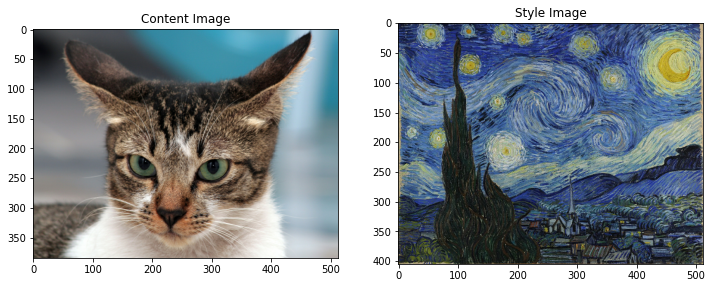

In [ ]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

In [ ]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [ ]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('Egyptian_cat', 0.3131617),
 ('tabby', 0.2850342),
 ('tiger_cat', 0.2549201),
 ('lynx', 0.03644176),
 ('ping-pong_ball', 0.006083066)]

In [ ]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)


input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [ ]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
         'block2_conv1',
         'block3_conv1', 
         'block4_conv1', 
         'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [ ]:
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [ ]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 405, 512, 64)
  min:  0.0
  max:  672.04034
  mean:  24.172132

block2_conv1
  shape:  (1, 202, 256, 128)
  min:  0.0
  max:  2986.961
  mean:  150.21454

block3_conv1
  shape:  (1, 101, 128, 256)
  min:  0.0
  max:  7542.732
  mean:  146.08536

block4_conv1
  shape:  (1, 50, 64, 512)
  min:  0.0
  max:  17030.152
  mean:  568.7065

block5_conv1
  shape:  (1, 25, 32, 512)
  min:  0.0
  max:  4112.168
  mean:  49.20106



In [ ]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [ ]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [ ]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.048378572
    max:  21237.34
    mean:  365.8864

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  57047.215
    mean:  10308.725

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  194638.5
    mean:  8558.84

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  3012394.0
    mean:  157313.0

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  100288.375
    mean:  1420.1368

Contents:
   block5_conv2
    shape:  (1, 24, 32, 512)
    min:  0.0
    max:  1922.6146
    mean:  14.641284


In [ ]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [ ]:
image = tf.Variable(content_image)

In [ ]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [ ]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [ ]:
style_weight=1e-2
content_weight=1e4

In [ ]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [ ]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [ ]:
# train_step(image)
# train_step(image)
# train_step(image)
# tensor_to_image(image)

In [ ]:
# import time
# start = time.time()

# epochs = 10
# steps_per_epoch = 100

# step = 0
# for n in range(epochs):
#   for m in range(steps_per_epoch):
#     step += 1
#     train_step(image)
#     print(step, end='\r', flush=True)
#   display.clear_output(wait=True)
#   display.display(tensor_to_image(image))
#   print("Train step: {}".format(step))

# end = time.time()

# print("Total time: {:.1f}".format(end-start))

torch.Size([3, 530, 530])


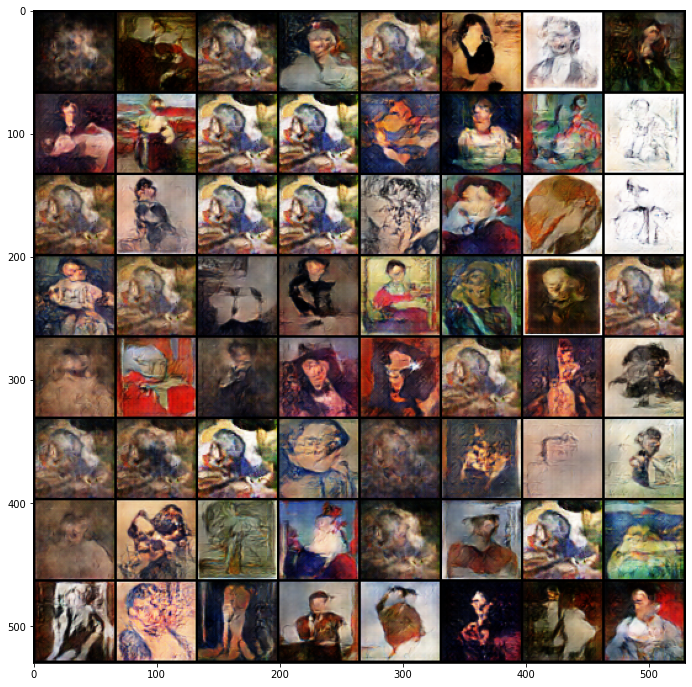

In [ ]:
x = torch.load("/content/drive/MyDrive/Colab_Notebooks_Dataset/output64_k5_z64/img_list.pt")
print(x[0].shape)
plt.imshow(np.transpose(x[180],(1,2,0)))
#plt.imshow(x[1].numpy().transpose(1,2,0)[:64,:64,:])
# for i in range(len(x)):
#   img = PIL.Image.fromarray(x[i].numpy().transpose(1,2,0), 'RGB')
#   img.save("/content/drive/MyDrive/Colab_Notebooks_Dataset/output64_k5_z64/{}.jpeg".format(i))

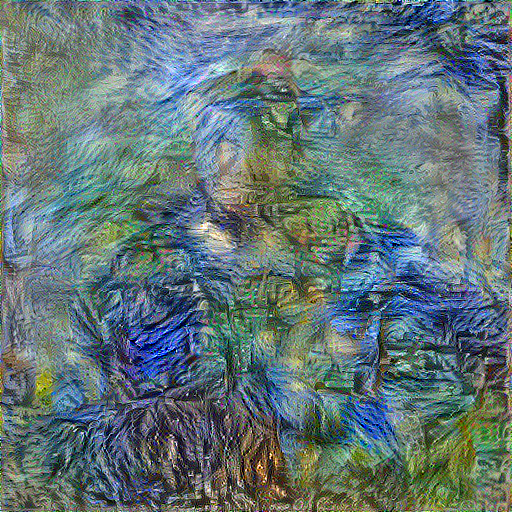

Train step: 500


In [ ]:
import time
import os
epochs = 10
steps_per_epoch = 100

style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

directory = "/content/drive/MyDrive/Colab_Notebooks_Dataset/style_image"
for f in os.listdir(directory):
  style_image = load_img(os.path.join(directory, f))
  for n in range(len(x)):
    if n >= 1: break
    for i in range(8):
      if i >= 1: break
      for j in range(8):
        print('n: {}, i: {}, j: {}'.format(n,i,j), end='\r')
        x_l = 2*(i+1)+64*i
        x_r = 2*(i+1)+64*(i+1)
        y_l = 2*(j+1)+64*j
        y_r = 2*(j+1)+64*(j+1)

        img_arr = x[n].numpy().transpose(1,2,0)[x_l:x_r,y_l:y_r,:]
        content_image = load_img2(img_arr)

        extractor = StyleContentModel(style_layers, content_layers)
        results = extractor(tf.constant(content_image))

        style_targets = extractor(style_image)['style']
        content_targets = extractor(content_image)['content']

        image = tf.Variable(content_image, name='{}_{}'.format(i,j))

        start = time.time()
        step = 0
        for n in range(epochs):
          for m in range(steps_per_epoch):
            step += 1
            train_step(image)
            print(step, end='\r', flush=True)
          display.clear_output(wait=True)
          display.display(tensor_to_image(image))
          print("Train step: {}".format(step))

        end = time.time()
        print("Total time: {:.1f}".format(end-start))
        pil_image = tensor_to_image(image)
        pil_image = pil_image.save('/content/drive/MyDrive/Colab_Notebooks_Dataset/output64_k5_z64/ST{}_{}_{}_{}.jpg'.format(f[:2],n,i,j))